# Validação Cruzada em Amostra (20%) com RandomForest e SMOTE

Objetivo: Amostrar 20% do dataset consolidado e executar validação cruzada em RandomForest, além de testar SMOTE para balanceamento.

In [1]:
# 1. Importar bibliotecas
import pandas as pd
import numpy as np
import ast
import os
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


## 2. Configurar caminhos e carregar dados

In [2]:
# Ajuste conforme sua estrutura de diretórios
BASE_DIR = os.getcwd()
csv_path = os.path.join(BASE_DIR, "dados", "df_consolidado.csv")
df_full = pd.read_csv(csv_path, low_memory=False)
print("🔄 Dataset carregado, total de registros:", len(df_full))

🔄 Dataset carregado, total de registros: 3126323


## 3. Limpar dados essenciais

In [3]:
print("📋 Removendo linhas com valores ausentes em colunas essenciais...")
colunas_para_remover_nan = [
    "id_votacao", "id_deputado", "tipoVoto", "siglaUf", "id_partido",
    "id_proposicao", "data", "sigla_orgao", "aprovacao", "cod_tipo",
    "numero_proposicao", "ano", "orientacao", "id_autor", "tema"
]
df_full = df_full.dropna(subset=colunas_para_remover_nan)
print(" Registros após limpeza:", len(df_full))

📋 Removendo linhas com valores ausentes em colunas essenciais...
 Registros após limpeza: 880952


## 4. Converter `tipoVoto` e definir `X_full`, `y_full`

In [4]:
print("🔢 Convertendo 'tipoVoto' para binário...")
df_full["tipoVoto"] = df_full["tipoVoto"].map({"Sim": 1, "Não": 0}).fillna(0)

print("🧮 Definindo features e alvo...")
y_full = df_full["aprovacao"].astype(int)

# Selecionar colunas brutas
features = ["siglaUf", "id_partido", "cod_tipo", "numero_proposicao", "ano", "tema"]
X_full = df_full[features].copy()

# Extrair tema_principal
def extrair_tema_principal(x):
    try:
        lst = ast.literal_eval(x) if pd.notnull(x) else []
        return lst[0] if len(lst) > 0 else "Outros"
    except:
        return "Outros"

X_full["tema_principal"] = X_full["tema"].apply(extrair_tema_principal)

# Manter colunas finais e converter id_partido para int
X_full = X_full[["siglaUf", "id_partido", "cod_tipo", "ano", "tema_principal"]]
X_full["id_partido"] = X_full["id_partido"].astype(int)

print(" Features finais:", X_full.columns.tolist())

🔢 Convertendo 'tipoVoto' para binário...
🧮 Definindo features e alvo...
 Features finais: ['siglaUf', 'id_partido', 'cod_tipo', 'ano', 'tema_principal']


## 5. Amostrar 20% dos dados (estratificado)

In [5]:
print("🎯 Amostrando 20% dos dados, mantendo proporcionalidade de classes...")
X_sub, _, y_sub, _ = train_test_split(
    X_full, y_full, test_size=0.80, stratify=y_full, random_state=42
)
print(f"🔎 Tamanho da amostra: {len(X_sub)} registros")

🎯 Amostrando 20% dos dados, mantendo proporcionalidade de classes...
🔎 Tamanho da amostra: 176190 registros


## 6. Pré-processamento dos features

In [6]:
print("⚙️ Configurando pipeline de pré-processamento...")
categorical_features = ["siglaUf", "tema_principal"]
numeric_features = ["id_partido", "cod_tipo", "ano"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

⚙️ Configurando pipeline de pré-processamento...


## 7. Validação Cruzada (5 folds) com RandomForest

In [7]:
print("🚀 Iniciando validação cruzada (5 folds) em RandomForest...")
model = RandomForestClassifier(random_state=42, n_jobs=-1)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", model),
    ]
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calcula F1-macro em cada fold
scores = cross_val_score(
    pipeline, X_sub, y_sub,
    cv=cv, scoring="f1_macro", n_jobs=-1, verbose=2
)
print("\n📊 Resultados F1-macro por fold:")
for i, score in enumerate(scores, start=1):
    print(f"  Fold {i}: {score:.4f}")
print(f"  Média: {scores.mean():.4f}  |  Desvio: {scores.std():.4f}")

🚀 Iniciando validação cruzada (5 folds) em RandomForest...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=  27.9s
[CV] END .................................................... total time=  28.1s
[CV] END .................................................... total time=  28.4s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.0s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.2s finished


[CV] END .................................................... total time=  28.4s
[CV] END .................................................... total time=  28.1s

📊 Resultados F1-macro por fold:
  Fold 1: 0.7346
  Fold 2: 0.7354
  Fold 3: 0.7356
  Fold 4: 0.7361
  Fold 5: 0.7347
  Média: 0.7353  |  Desvio: 0.0006


## 8. Treino/Teste e Matriz de Confusão


🔍 Treinando modelo em treino/teste e gerando matriz de confusão...

✅ Relatório de Classificação (amostra 20%):
              precision    recall  f1-score   support

           0       0.77      0.96      0.85     22690
           1       0.86      0.48      0.62     12548

    accuracy                           0.79     35238
   macro avg       0.82      0.72      0.74     35238
weighted avg       0.80      0.79      0.77     35238


🔲 Matriz de Confusão:


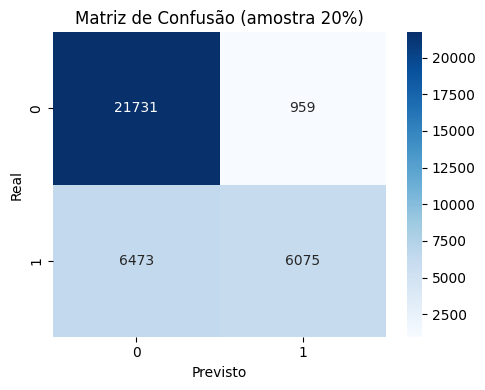

In [8]:
print("\n🔍 Treinando modelo em treino/teste e gerando matriz de confusão...")
X_train, X_test, y_train, y_test = train_test_split(
    X_sub, y_sub, stratify=y_sub, test_size=0.20, random_state=42
)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("\n✅ Relatório de Classificação (amostra 20%):")
print(classification_report(y_test, y_pred))

print("\n🔲 Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (amostra 20%)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

## 9. Boxplot de F1-macro nas 5 folds

📈 Gerando boxplot final dos F1-macro nas folds...


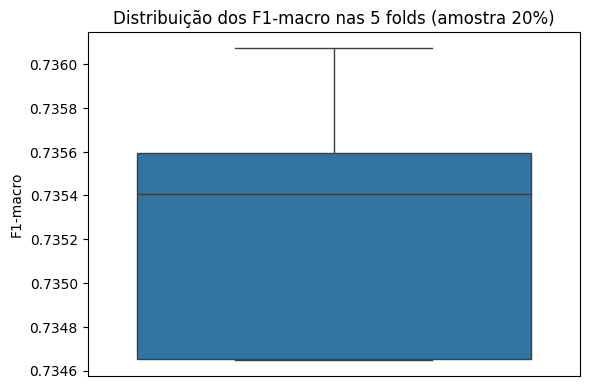

In [9]:
print("📈 Gerando boxplot final dos F1-macro nas folds...")
plt.figure(figsize=(6, 4))
sns.boxplot(data=[scores])
plt.title("Distribuição dos F1-macro nas 5 folds (amostra 20%)")
plt.ylabel("F1-macro")
plt.xticks([])
plt.tight_layout()
plt.show()

## 10. Teste com SMOTE (Oversampling da Classe Positiva)

In [10]:
print("\n🧪 TENTATIVA COM SMOTE (oversampling da classe 1)...")

# Pipeline com SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
pipeline_smote = ImbPipeline([
    ("smote", smote),
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])

# (1) Validação cruzada com SMOTE
scores_smote = cross_val_score(
    pipeline_smote,
    X_sub, y_sub,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)
print("\n📊 Scores F1-macro (SMOTE) por fold:", scores_smote)
print(f"Média (SMOTE): {scores_smote.mean():.4f}  |  Desvio: {scores_smote.std():.4f}")

# (2) Treino/Teste com SMOTE e Matriz de Confusão
X_tr_smote, X_te_smote, y_tr_smote, y_te_smote = train_test_split(
    X_sub, y_sub, stratify=y_sub, test_size=0.20, random_state=42
)
pipeline_smote.fit(X_tr_smote, y_tr_smote)
y_pred_smote = pipeline_smote.predict(X_te_smote)

print("\n✅ Relatório (SMOTE):")
print(classification_report(y_te_smote, y_pred_smote))

print("\n🔲 Matriz de Confusão (SMOTE):")
cm_smote = confusion_matrix(y_te_smote, y_pred_smote)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão (SMOTE)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


🧪 TENTATIVA COM SMOTE (oversampling da classe 1)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.1s


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 440, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
                               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 1336, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 202, in fit_resample
    return super().fit_resample(X, y, **params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 99, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 157, in _check_X_y
    X, y = validate_data(self, X=X, y=y, reset=True, accept_sparse=accept_sparse)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'MA'

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_params, raw_params=params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 440, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
                               ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/pipeline.py", line 1336, in _fit_resample_one
    X_res, y_res = sampler.fit_resample(X, y, **params.get("fit_resample", {}))
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 202, in fit_resample
    return super().fit_resample(X, y, **params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 99, in fit_resample
    X, y, binarize_y = self._check_X_y(X, y)
                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/imblearn/base.py", line 157, in _check_X_y
    X, y = validate_data(self, X=X, y=y, reset=True, accept_sparse=accept_sparse)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1055, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/sklearn/utils/_array_api.py", line 839, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/luizfelipebessa/Documents/Faculdade/ML/CdD-ML/venv/lib/python3.11/site-packages/pandas/core/generic.py", line 2153, in __array__
    arr = np.asarray(values, dtype=dtype)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'PB'


## 11. Resumo de Falsos Negativos (FN) por Configuração

In [11]:
import pandas as pd

resumo = []
# (i) Modelo-base (threshold=0.50)
tn, fp, fn, tp = cm.ravel()
resumo.append({
    "configuração": "Base (cw=balanced, thr=0.5)",
    "TN": tn, "FP": fp, "FN": fn, "TP": tp
})

# (ii) SMOTE
tn2, fp2, fn2, tp2 = cm_smote.ravel()
resumo.append({
    "configuração": "SMOTE (1/0=0.5)",
    "TN": tn2, "FP": fp2, "FN": fn2, "TP": tp2
})

df_resumo = pd.DataFrame(resumo)
display(df_resumo)

# Gráfico de comparação de FN
plt.figure(figsize=(6,4))
sns.barplot(data=df_resumo, x="configuração", y="FN", palette="Set2")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Quantidade de Falsos Negativos")
plt.title("Comparação de FN entre Configurações")
plt.tight_layout()
plt.show()

NameError: name 'cm_smote' is not defined

## Fim do Notebook